Standard python implementation of ising model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def run_sim(N, sweeps, J, T, thermalisation=10):
    A = np.asarray(np.round(np.random.rand(N,N)), dtype=np.int8)
    A[A == 0] = -1
    AvgMag = 0.0
    averaged = 0
    sweep = 0
    while sweep < sweeps + thermalisation:
        x = 0 
        while x < N*N:
            i = np.random.randint(N)
            j = np.random.randint(N)        
            deltaE = 0.0
            if i < (N-1):
                deltaE += 2*J*A[i,j]*A[i+1,j]
            else:
                deltaE += 2*J*A[i,j]*A[0,j]
            if i > 0:
                deltaE += 2*J*A[i,j]*A[i-1,j]
            else:
                deltaE += 2*J*A[i,j]*A[-1,j]
            if j < (N-1):
                deltaE += 2*J*A[i,j]*A[i,j+1]
            else:
                deltaE += 2*J*A[i,j]*A[i,0]
            if j > 0:
                deltaE += 2*J*A[i,j]*A[i,j-1]
            else:
                deltaE += 2*J*A[i,j]*A[i,-1]
            if deltaE < 0.0:
                A[i,j] *= -1
            else:
                roll = np.random.rand()
                if roll < np.exp(-deltaE/T):
                    A[i,j] *= -1
            x += 1
        if sweep >= thermalisation:            
            AvgMag = (AvgMag*averaged + np.sum(A)/float(N*N))/float(averaged+1)
            averaged += 1
        sweep += 1
            
    return AvgMag, A

In [2]:
%%time
N = 20
J = 1.0
T = 0.5
sweeps = 20
mag, A = run_sim(N, sweeps, J, T, thermalisation=50)

CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 344 ms


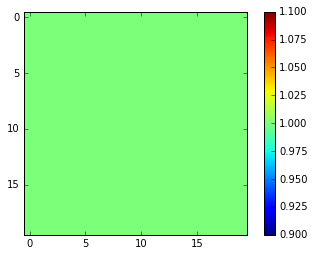

In [3]:
plt.imshow(A, interpolation='nearest')
plt.colorbar()

We now do the same in cython.

In [4]:
%load_ext Cython

In [5]:
%%cython 

cimport numpy as np
import numpy as np
cimport cython

cdef extern from "math.h":
    double exp(double x)
    
from libc.stdlib cimport rand, RAND_MAX            
    
@cython.boundscheck(False)
@cython.wraparound(False)
def run_sim_cython(int N, int sweeps, double J, double T, int thermalisation=10):
    cdef np.ndarray[np.int8_t, ndim=2] A = np.asarray(np.round(np.random.rand(N,N)), dtype=np.int8) 
    A[A == 0] = -1
    cdef double AvgMag = 0.0, averaged = 0, deltaE, roll
    cdef int x, sweep=0, i, j
    cdef int sites = N**2
    cdef np.ndarray[np.int_t, ndim=2] rand_sites
    cdef double rand_denominator = RAND_MAX

    while sweep < (sweeps + thermalisation):    
        x = 0
        while x < sites:
            i = np.random.randint(N)
            j = np.random.randint(N)        
            deltaE = 0.0
            if i < (N-1):
                deltaE += 2*J*A[i,j]*A[i+1,j]
            else:
                deltaE += 2*J*A[i,j]*A[0,j]
            if i > 0:
                deltaE += 2*J*A[i,j]*A[i-1,j]
            else:
                deltaE += 2*J*A[i,j]*A[-1,j]
            if j < (N-1):
                deltaE += 2*J*A[i,j]*A[i,j+1]
            else:
                deltaE += 2*J*A[i,j]*A[i,0]
            if j > 0:
                deltaE += 2*J*A[i,j]*A[i,j-1]
            else:
                deltaE += 2*J*A[i,j]*A[i,-1]
            if deltaE < 0.0:
                A[i,j] *= -1
            else:
                roll = rand()/rand_denominator
                if roll < exp(-deltaE/T):
                    A[i,j] *= -1
            x += 1
        if sweep >= thermalisation:            
            AvgMag = (AvgMag*averaged + np.sum(A)/float(N*N))/float(averaged+1)
            averaged += 1
        sweep += 1
            
    return AvgMag, A
    

In [6]:
%time
N = 20
J = 1.0
sweeps = 20
T = 0.1
average_mag, A = run_sim_cython(N, sweeps, J, T, thermalisation=50)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs


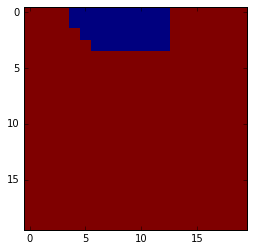

In [7]:
plt.imshow(A, interpolation='nearest')

In [10]:
%%time
Ts = np.linspace(0.1, 10.0, 30)
sweeps = 100
N = 20

avg_mag = []
for T in Ts:
    data = run_sim_cython(N, sweeps, J, T, thermalisation=50)
    avg_mag.append(data[0])

CPU times: user 5.07 s, sys: 8 ms, total: 5.08 s
Wall time: 5.08 s


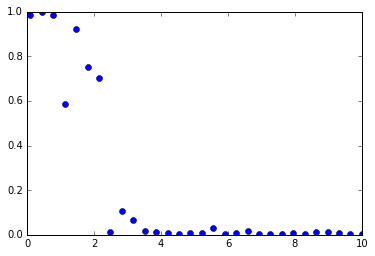

In [9]:
plt.plot(list(Ts), np.abs(avg_mag), 'o')